<a href="https://colab.research.google.com/github/alastra32/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/module3-databackedassertions/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [1]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [2]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [3]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something
import numpy as np

users = []

for _ in range(250):
  # Desktop users
  #time_on_site = random.uniform(10, 600)
  time_on_site = np.random.normal(9.4*60, 3*60)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  #time_on_site = random.uniform(5, 300)
  time_on_site = np.random.normal(7.5*60, 2.5*60)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=589.5716821360311, mobile=True), User(purchased=True, time_on_site=322.58929703314277, mobile=True), User(purchased=True, time_on_site=521.3561349113759, mobile=True), User(purchased=False, time_on_site=679.6851171240669, mobile=True), User(purchased=True, time_on_site=740.8027740900624, mobile=False), User(purchased=True, time_on_site=572.3701830827174, mobile=True), User(purchased=False, time_on_site=438.9813381602747, mobile=True), User(purchased=False, time_on_site=305.50952403255155, mobile=True), User(purchased=True, time_on_site=205.57204330259927, mobile=True), User(purchased=True, time_on_site=411.0695301200322, mobile=True)]


In [4]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,589.571682,True
1,True,322.589297,True
2,True,521.356135,True
3,False,679.685117,True
4,True,740.802774,False


In [5]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,-84.94736472646207,-14.430851765010402,18.219825403894447,49.40136814817788,54.11735195641404,66.31063327773126,76.67764830288269,88.96012204495247,97.3860813228593,112.55009795113853,115.85167008684726,120.43863567269375,121.57090445294358,128.57416633636,131.51763003482233,133.14746921790095,134.27166498287943,139.8466183137292,141.51902014503162,147.93017120323043,150.02718218966436,154.4721865429458,154.60918719699959,161.44762246094137,164.040675991079,168.90382428958628,169.69096299028524,169.9913986001062,171.25512065250985,173.26416942442734,174.35847377395004,178.64761727366175,180.52871991024728,182.13188370370824,184.73876791075702,186.53218977426593,187.99839971111732,188.06262889061873,189.61960551089533,192.32843299502446,...,779.6611000743642,780.8500932855154,781.7767940748163,786.5250024035851,788.1546677977414,791.1648307651815,791.8861650049176,792.8546652522515,795.900320095208,797.5436813316583,797.803606646127,798.2211881327528,798.8930880167223,801.3207234773238,803.1683988235297,806.6153425609234,812.8445992516042,815.9353267251615,817.765224032373,819.2995372407111,820.4612788564552,823.3394191779735,845.4039005395191,853.7881146172938,858.5881276420068,860.1123589073245,860.4508481164415,862.1228003522053,892.8933641583304,894.7921720501058,911.0398668379632,912.3210074423542,916.3653568255694,920.9298263444717,926.045404344105,946.8623435226604,954.1673525839418,958.0895875410779,984.4236355306591,1020.2950494157567
purchased,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,0,1,0,1,0,1,0,1,1,1,0,1,1,1,1,1,1,0,1,0,0,0,0,1,0,0,0,1,1,1,1,1,1,0,0,1,1,0,1,1,...,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
True,1,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,1,1,1,0,1,1,1,0,0,0,0,0,0,1,1,0,0,1,0,0,...,1,1,1,0,1,0,1,1,0,1,1,0,1,1,1,1,0,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,0,1,1,1,1,1,1,1


In [6]:
user_data[user_data.time_on_site<0.0]

,purchased,time_on_site,mobile
14,False,-14.430852,True
170,True,-84.947365,True


In [7]:
user_data.loc[user_data['time_on_site']<0.0, 'time_on_site']=0.0 #changing negative observations to zero
user_data[user_data['time_on_site'] < 0.0]

,purchased,time_on_site,mobile


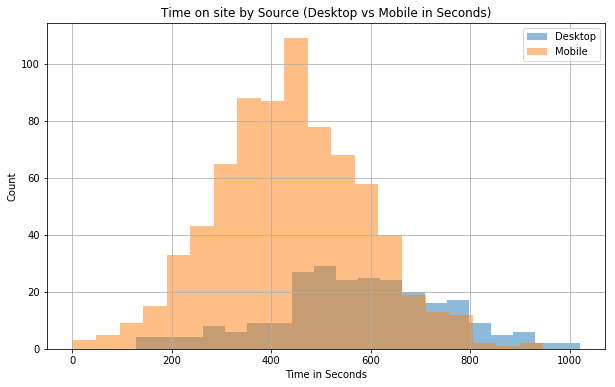

In [8]:
import matplotlib.pyplot as plt

user_data.groupby('mobile').time_on_site.hist(bins = 20, alpha =0.5, figsize=(10,6));
plt.title ('Time on site by Source (Desktop vs Mobile in Seconds)')
plt.ylabel('Count')
plt.xlabel('Time in Seconds')
plt.legend(['Desktop','Mobile'])

In [9]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(time_bins,user_data['purchased'] )

purchased,False,True
time_on_site,,
"(-1.02, 204.059]",30,20
"(204.059, 408.118]",152,147
"(408.118, 612.177]",183,271
"(612.177, 816.236]",57,118
"(816.236, 1020.295]",3,19


In [10]:
time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(time_bins,user_data['purchased'], normalize='index' )

purchased,False,True
time_on_site,,
"(-1.02, 204.059]",0.600000,0.400000
"(204.059, 408.118]",0.508361,0.491639
"(408.118, 612.177]",0.403084,0.596916
"(612.177, 816.236]",0.325714,0.674286
"(816.236, 1020.295]",0.136364,0.863636


In [11]:
pd.crosstab(columns=user_data['purchased'], index=time_bins, normalize='index') #otherway without error

purchased,False,True
time_on_site,,
"(-1.02, 204.059]",0.600000,0.400000
"(204.059, 408.118]",0.508361,0.491639
"(408.118, 612.177]",0.403084,0.596916
"(612.177, 816.236]",0.325714,0.674286
"(816.236, 1020.295]",0.136364,0.863636


In [12]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(time_bins,user_data['purchased'],  normalize='columns')

purchased,False,True
time_on_site,,
"(-1.02, 204.059]",0.070588,0.034783
"(204.059, 408.118]",0.357647,0.255652
"(408.118, 612.177]",0.430588,0.471304
"(612.177, 816.236]",0.134118,0.205217
"(816.236, 1020.295]",0.007059,0.033043


In [13]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.492,0.402667
True,0.508,0.597333


In [14]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

pd.crosstab(time_bins, [user_data['purchased'],user_data['mobile']], normalize='columns') # Multi level crosstab!!!!

purchased               False               True           
mobile                  False     True      False     True 
time_on_site                                               
(-1.02, 204.059]     0.032520  0.086093  0.015748  0.040179
(204.059, 408.118]   0.154472  0.440397  0.086614  0.303571
(408.118, 612.177]   0.512195  0.397351  0.362205  0.502232
(612.177, 816.236]   0.276423  0.076159  0.409449  0.147321
(816.236, 1020.295]  0.024390  0.000000  0.125984  0.006696

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself





df = pd.read_csv('https://raw.githubusercontent.com/alastra32/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module3-databackedassertions/persons.csv')


##Loading Data & Libraries

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('https://raw.githubusercontent.com/alastra32/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module3-databackedassertions/persons.csv',index_col=0)
df.head()

,age,weight,exercise_time
0,44,118,192
1,41,161,35
2,46,128,220
3,39,216,57
4,28,116,182


##Analysis of the Data

In [17]:
df.describe()

,age,weight,exercise_time
count,1200.000000,1200.000000,1200.000000
mean,48.396667,153.540833,134.910833
std,18.166802,35.132182,85.548895
min,18.000000,100.000000,0.000000
25%,33.000000,125.000000,65.000000
50%,48.000000,149.000000,122.000000
75%,64.000000,180.250000,206.000000
max,80.000000,246.000000,300.000000


In [18]:
df.isna().sum()

age              0
weight           0
exercise_time    0
dtype: int64

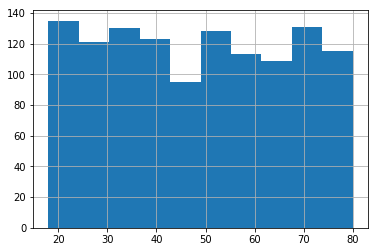

In [19]:
df['age'].hist();

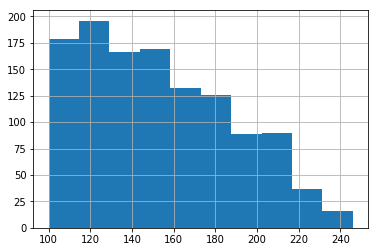

In [20]:
df['weight'].hist()

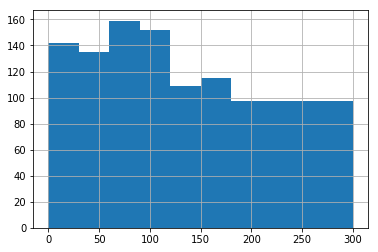

In [21]:
df['exercise_time'].hist()

**First Observation**: The distribution of our samples by age is nearly uniform or has fat tails. The distribution of the weight is skewed to the right, meaning we have more observations of lower weight. And the distribution of the exercise time is slightly less also skewed to the right, also meaning we have more observations of less exercise time.


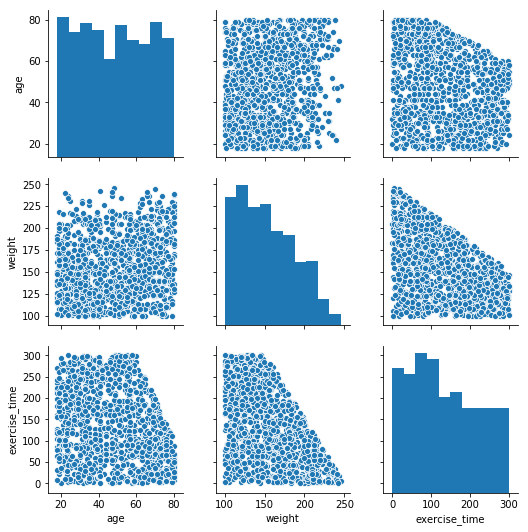

In [22]:
sns.pairplot(df);

In [23]:
df['age_bins']=pd.cut(df['age'],[18,30,40,50,60,70,80])
df['weight_bins'] = pd.cut(df['weight'],10)
df['exercise_bins'] = pd.cut(df['exercise_time'],10)
print(df.shape)
df.head()


(1200, 6)


,age,weight,exercise_time,age_bins,weight_bins,exercise_bins
0,44,118,192,"(40, 50]","(114.6, 129.2]","(180.0, 210.0]"
1,41,161,35,"(40, 50]","(158.4, 173.0]","(30.0, 60.0]"
2,46,128,220,"(40, 50]","(114.6, 129.2]","(210.0, 240.0]"
3,39,216,57,"(30, 40]","(202.2, 216.8]","(30.0, 60.0]"
4,28,116,182,"(18, 30]","(114.6, 129.2]","(180.0, 210.0]"


In [29]:
!pip install pandas==0.23.4 #needed a prior version of Pandas in order for Crosstabs to work for bin categories.

In [25]:
pd.crosstab(df['age_bins'],df['weight_bins'],normalize='all')

weight_bins,"(99.854, 114.6]","(114.6, 129.2]","(129.2, 143.8]","(143.8, 158.4]","(158.4, 173.0]","(173.0, 187.6]","(187.6, 202.2]","(202.2, 216.8]","(216.8, 231.4]","(231.4, 246.0]"
age_bins,,,,,,,,,,
"(18, 30]",0.033898,0.027966,0.029661,0.036441,0.025424,0.013559,0.012712,0.014407,0.003390,0.002542
"(30, 40]",0.033051,0.041525,0.020339,0.022034,0.015254,0.020339,0.007627,0.015254,0.005085,0.000000
"(40, 50]",0.019492,0.028814,0.026271,0.016949,0.020339,0.011864,0.006780,0.007627,0.002542,0.003390
"(50, 60]",0.022881,0.029661,0.017797,0.025424,0.015254,0.016949,0.011864,0.014407,0.000847,0.000847
"(60, 70]",0.021186,0.018644,0.025424,0.026271,0.019492,0.015254,0.019492,0.012712,0.005085,0.004237
"(70, 80]",0.019492,0.015254,0.016102,0.014407,0.022034,0.020339,0.015254,0.011864,0.014407,0.002542


In [26]:
pd.crosstab(df['age_bins'],df['exercise_bins'],normalize='all')

exercise_bins,"(-0.3, 30.0]","(30.0, 60.0]","(60.0, 90.0]","(90.0, 120.0]","(120.0, 150.0]","(150.0, 180.0]","(180.0, 210.0]","(210.0, 240.0]","(240.0, 270.0]","(270.0, 300.0]"
age_bins,,,,,,,,,,
"(18, 30]",0.016949,0.025424,0.017797,0.016102,0.017797,0.024576,0.021186,0.025424,0.021186,0.013559
"(30, 40]",0.017797,0.019492,0.014407,0.024576,0.010169,0.018644,0.018644,0.016102,0.018644,0.022034
"(40, 50]",0.012712,0.014407,0.016949,0.012712,0.011017,0.013559,0.009322,0.011864,0.026271,0.015254
"(50, 60]",0.013559,0.010169,0.019492,0.016102,0.015254,0.015254,0.012712,0.014407,0.013559,0.025424
"(60, 70]",0.026271,0.015254,0.028814,0.028814,0.016102,0.021186,0.015254,0.011864,0.004237,0.000000
"(70, 80]",0.038136,0.023729,0.038983,0.027966,0.016949,0.005085,0.000847,0.000000,0.000000,0.000000


In [27]:
pd.crosstab(df['weight_bins'],df['exercise_bins'],normalize='all')

exercise_bins,"(-0.3, 30.0]","(30.0, 60.0]","(60.0, 90.0]","(90.0, 120.0]","(120.0, 150.0]","(150.0, 180.0]","(180.0, 210.0]","(210.0, 240.0]","(240.0, 270.0]","(270.0, 300.0]"
weight_bins,,,,,,,,,,
"(99.854, 114.6]",0.011667,0.010833,0.013333,0.010000,0.017500,0.016667,0.015000,0.016667,0.014167,0.023333
"(114.6, 129.2]",0.010000,0.011667,0.012500,0.018333,0.010833,0.014167,0.015833,0.018333,0.030833,0.020833
"(129.2, 143.8]",0.009167,0.008333,0.018333,0.008333,0.009167,0.017500,0.014167,0.018333,0.016667,0.018333
"(143.8, 158.4]",0.011667,0.007500,0.020833,0.015833,0.010000,0.019167,0.012500,0.016667,0.014167,0.012500
"(158.4, 173.0]",0.010833,0.015000,0.020000,0.019167,0.011667,0.011667,0.010000,0.010833,0.007500,0.000833
"(173.0, 187.6]",0.012500,0.012500,0.019167,0.019167,0.010833,0.012500,0.010000,0.000833,0.000000,0.000000
"(187.6, 202.2]",0.015833,0.009167,0.012500,0.013333,0.015833,0.006667,0.000833,0.000000,0.000000,0.000000
"(202.2, 216.8]",0.018333,0.020000,0.013333,0.021667,0.001667,0.000000,0.000000,0.000000,0.000000,0.000000
"(216.8, 231.4]",0.013333,0.010000,0.006667,0.000833,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


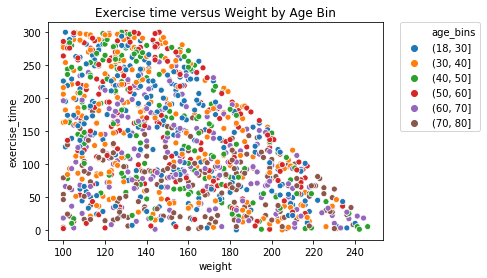

In [32]:
sns.scatterplot(x='weight',y='exercise_time',hue='age_bins',data= df);
plt.title('Exercise time versus Weight by Age Bin');
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

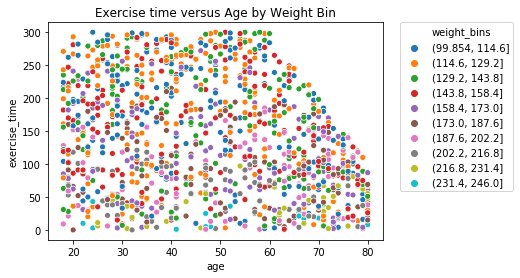

In [31]:
sns.scatterplot(x='age',y='exercise_time',hue='weight_bins',data= df);
plt.title('Exercise time versus Age by Weight Bin');
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

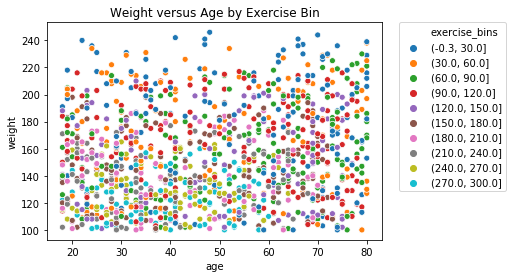

In [38]:
sns.scatterplot(x='age',y='weight',hue='exercise_bins',data= df);
plt.title('Weight versus Age by Exercise Bin');
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

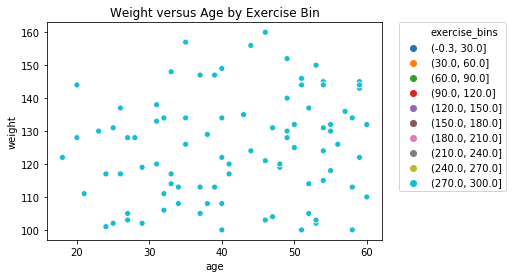

In [39]:
sns.scatterplot(x='age',y='weight',hue='exercise_bins',data= df[df['exercise_time']>270.0]);
plt.title('Weight versus Age by Exercise Bin');
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

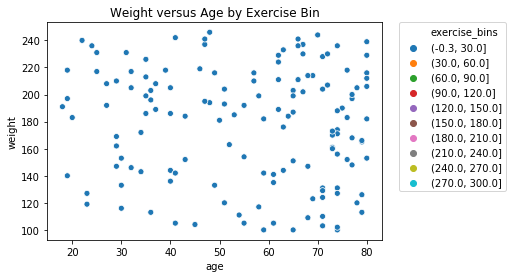

In [40]:
sns.scatterplot(x='age',y='weight',hue='exercise_bins',data= df[df['exercise_time']<30.0]);
plt.title('Weight versus Age by Exercise Bin');
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?

The variable types in the block are all continuous variables.

2.  What are the relationships between the variables?

As we see the variable Weight go up in our observations, we can see Exercise Time decrease.

As we see the variable Age go up in our observations, we can see Exercise Time decrease.

3.  Which relationships are "real", and which spurious?

The real relationships are between Weight and Exercise Time, as well as Exercise Time and Age.

The spurious relationship is between Age and Weight. We don't see any correlation between Age and Weight.

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)